# Augmented VAE training

In [1]:
%load_ext autoreload
%autoreload 2

import os


os.environ["WANDB_NOTEBOOK_NAME"] = "aug_vae.ipynb"
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"
# XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

from itertools import product
from pathlib import Path

import ciclo
import flax
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import wandb
from absl import logging
from clu import deterministic_data
from jax.config import config as jax_config
from ml_collections import config_dict

from experiments.utils import load_checkpoint, save_checkpoint
from src.models.aug_vae import (
    AUG_VAE,
    create_aug_vae_state,
    make_aug_vae_plotting_fns,
    make_aug_vae_train_and_eval,
)
from src.models.transformation_generative_model import (
    TransformationGenerativeNet,
    create_transformation_generative_state,
    make_transformation_generative_train_and_eval,
)
from src.models.transformation_inference_model import (
    TransformationInferenceNet,
    create_transformation_inference_state,
    make_transformation_inference_train_and_eval,
)
from src.models.utils import reset_metrics
from src.transformations.affine import gen_affine_matrix_no_shear
from src.utils.gen_plots import plot_gen_dists, plot_gen_model_training_metrics
from src.utils.input import get_data
from src.utils.proto_plots import (
    make_get_prototype_fn,
    plot_proto_model_training_metrics,
    plot_protos_and_recons,
)
from src.utils.training import custom_wandb_logger
from experiments.configs.inf_best import get_config as get_inf_config
from experiments.configs.gen_best import get_config as get_gen_config
from experiments.configs.vae_mnist import get_config as get_vae_config

flax.config.update("flax_use_orbax_checkpointing", True)
logging.set_verbosity(logging.INFO)
plt.rcParams["savefig.facecolor"] = "white"


/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I0000 00:00:1704487284.654048 1056171 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
ANGLE = 180
inf_config = get_inf_config(f"MNIST,0,{ANGLE},50000")
inf_config.steps = 10_000
gen_config = get_gen_config(f"MNIST,0,{ANGLE},50000")
gen_config.steps = 10_000
vae_config = get_vae_config(f"{ANGLE}")
vae_config.steps = 10_000

In [3]:
inf_config.checkpoint = f"ckpts/inf_mnist_{ANGLE}"
gen_config.checkpoint = f"ckpts/gen_mnist_{ANGLE}"
# vae_config.checkpoint = f"ckpts/vae_mnist_{ANGLE}"

## Train Inf

In [4]:
rng = random.PRNGKey(inf_config.seed)
data_rng, init_rng = random.split(rng)

In [5]:
train_ds, val_ds, _ = get_data(inf_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'labe

In [6]:
inf_model = TransformationInferenceNet(
    bounds=inf_config.get("augment_bounds", None),
    offset=inf_config.get("augment_offset", None),
    **inf_config.model.to_dict(),
)

inf_state = create_transformation_inference_state(
    inf_model, inf_config, init_rng, input_shape
)

INFO:absl:
+--------------------------------+--------------+-----------+-----------+--------+
| Name                           | Shape        | Size      | Mean      | Std    |
+--------------------------------+--------------+-----------+-----------+--------+
| params/Dense_0/bias            | (5,)         | 5         | 0.0       | 0.0    |
| params/Dense_0/kernel          | (256, 5)     | 1,280     | 0.0       | 0.0    |
| params/MLP_0/Dense_0/bias      | (2048,)      | 2,048     | 0.0       | 0.0    |
| params/MLP_0/Dense_0/kernel    | (784, 2048)  | 1,605,632 | 1.81e-05  | 0.0357 |
| params/MLP_0/Dense_1/bias      | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/MLP_0/Dense_1/kernel    | (2048, 1024) | 2,097,152 | 4.55e-07  | 0.0221 |
| params/MLP_0/Dense_2/bias      | (512,)       | 512       | 0.0       | 0.0    |
| params/MLP_0/Dense_2/kernel    | (1024, 512)  | 524,288   | -3.06e-05 | 0.0312 |
| params/MLP_0/Dense_3/bias      | (256,)       | 256       | 0.0       | 0.

In [7]:
inf_model_checkpoint_path = inf_config.get("checkpoint", "")
if (
    inf_model_checkpoint_path != ""
    and not Path(inf_model_checkpoint_path).exists()
):    
    run = wandb.init(
        project="iclr2024experiments",
        entity="invariance-learners",
        config=inf_config.to_dict(),
        mode="offline",
        notes="",
        name=None,
        settings=wandb.Settings(code_dir="../"),
    )
    
    train_step, eval_step = make_transformation_inference_train_and_eval(
        inf_model, inf_config
    )

    inf_final_state, history, _ = ciclo.train_loop(
        inf_state,
        deterministic_data.start_input_pipeline(train_ds),
        {
            ciclo.on_train_step: [train_step],
            ciclo.on_reset_step: reset_metrics,
            ciclo.on_test_step: eval_step,
        },
        test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
        epoch_duration=int(inf_config.steps * inf_config.eval_freq),
        callbacks=[
            ciclo.keras_bar(total=inf_config.steps),
        ],
        stop=inf_config.steps + 1,
    )

    save_checkpoint(inf_model_checkpoint_path, inf_final_state, inf_config)

    fig = plot_proto_model_training_metrics(history)
    run.summary["proto_training_metrics"] = wandb.Image(fig)
    plt.close(fig)
         
    run.finish()
else:
    inf_final_state, _ = load_checkpoint(
        inf_model_checkpoint_path, inf_state, inf_config
    )

10000/10000 [==============================] - 454s 45ms/step - invertibility_loss: 0.0028 - loss: 0.0727 - x_mse: 0.0724 - η_recon_loss: 0.1543 - invertibility_loss_test: 0.0027 - loss_test: 0.0730 - x_mse_test: 0.0727 - η_recon_loss_test: 0.1535 - label_paired_image_mse_test: 0.4306  - ETA: 10:17:40 - invertibility_loss: 0.0015 - loss: 0.4922 - x_mse: 0.4921 - η_recon_loss: 0.6030 - invertibility_loss_test: 0.0014 - loss_test: 0.4936 - x_mse_test: 0.4935 - η_recon_loss_test: 0.5995 - label_paired_image_mse_test: 0.0000e+ - ETA: 8:01:29 - invertibility_loss: 0.0014 - loss: 0.4923 - x_mse: 0.4922 - η_recon_loss: 0.6019 - invertibility_loss_test: 0.0014 - loss_test: 0.4936 - x_mse_test: 0.4935 - η_recon_loss_test: 0.5995 - label_paired_image_mse_test: 0.0000e+00 - ETA: 6:34:49 - invertibility_loss: 0.0014 - loss: 0.4916 - x_mse: 0.4915 - η_recon_loss: 0.6004 - invertibility_loss_test: 0.0014 - loss_test: 0.4936 - x_mse_test: 0.4935 - η_recon_loss_test: 0.5995 - label_paired_image_mse_te

INFO:absl:Saving model checkpoint to ckpts/inf_mnist_180.
INFO:absl:OCDBT is initialized successfully.
INFO:absl:Saving item to ckpts/inf_mnist_180.
INFO:absl:Renaming ckpts/inf_mnist_180.orbax-checkpoint-tmp-1704487754538723 to ckpts/inf_mnist_180
INFO:absl:Finished saving checkpoint to `ckpts/inf_mnist_180`.


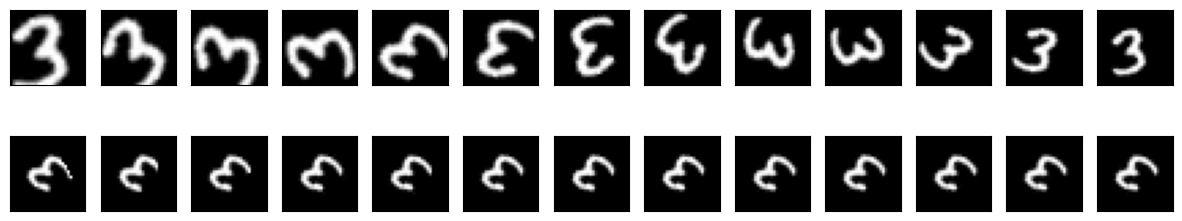

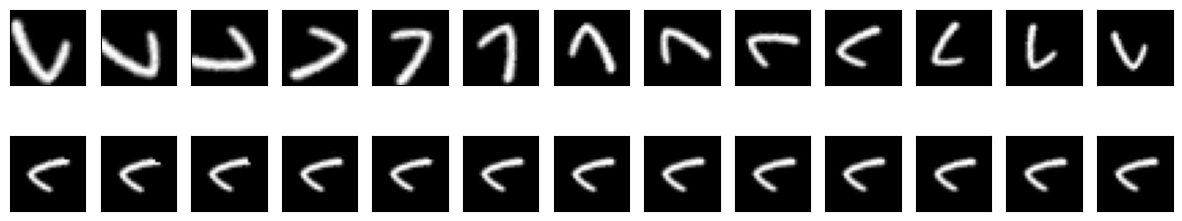

In [8]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

get_prototype = make_get_prototype_fn(
    inf_model,
    inf_final_state,
    rng,
    inf_config.interpolation_order,
    gen_affine_matrix_no_shear,
)

for i, (x_, mask) in enumerate(
    product(
        [
            val_batch["image"][0][14],
            val_batch["image"][0][12],
            # val_batch["image"][0][1],
            # val_batch["image"][0][4],
            # val_batch["image"][0][9],
        ],
        [
            # jnp.array([0, 0, 1, 0, 0]),
            # jnp.array([1, 1, 0, 0, 0]),
            jnp.array([1, 1, 1, 1, 1]),
        ],
    )
):
    fig = plot_protos_and_recons(
        x_, jnp.array(inf_config.augment_bounds) * mask, get_prototype
    )
    try:
        run.summary[f"inf_plots_{i}"] = wandb.Image(fig)
    except:
        pass
    plt.show(fig)
    plt.close(fig)

## Train Gen

In [9]:
def prototype_function(x, rng):
    η = inf_model.apply(
        {"params": inf_final_state.params}, x, train=False
    ).sample(seed=rng)
    return η

In [10]:
rng = random.PRNGKey(gen_config.seed)
data_rng, init_rng = random.split(rng)

In [11]:
train_ds, val_ds, _ = get_data(gen_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'labe

INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]', 'label': 'int64[]'}


In [12]:
gen_model = TransformationGenerativeNet(
    bounds=gen_config.get("augment_bounds", None),
    offset=gen_config.get("augment_offset", None),
    **gen_config.model.to_dict(),
)

gen_state = create_transformation_generative_state(
    gen_model,
    gen_config,
    init_rng,
    input_shape,
)

INFO:absl:
+----------------------------------------------+-------------+---------+-----------+--------+
| Name                                         | Shape       | Size    | Mean      | Std    |
+----------------------------------------------+-------------+---------+-----------+--------+
| params/Conditioner_0/Dense_0/bias            | (95,)       | 95      | 0.0       | 0.0    |
| params/Conditioner_0/Dense_0/kernel          | (256, 95)   | 24,320  | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/Dense_0/bias      | (256,)      | 256     | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/Dense_0/kernel    | (261, 256)  | 66,816  | 0.000127  | 0.0618 |
| params/Conditioner_0/MLP_0/LayerNorm_0/bias  | (256,)      | 256     | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/LayerNorm_0/scale | (256,)      | 256     | 1.0       | 0.0    |
| params/Conditioner_1/Dense_0/bias            | (95,)       | 95      | 0.0       | 0.0    |
| params/Conditioner_1/Dense_0/kernel          | 

In [13]:
gen_model_checkpoint_path = gen_config.get("checkpoint", "")
if (
    gen_model_checkpoint_path != ""
    and not Path(gen_model_checkpoint_path).exists()
):
    run = wandb.init(
        project="iclr2024experiments",
        entity="invariance-learners",
        config=gen_config.to_dict(),
        mode="offline",
        notes="",
        name=None,
        settings=wandb.Settings(code_dir="../"),
    )

    train_step, eval_step = make_transformation_generative_train_and_eval(
        gen_model, gen_config, prototype_function=prototype_function
    )

    gen_final_state, history, _ = ciclo.train_loop(
        gen_state,
        deterministic_data.start_input_pipeline(train_ds),
        {
            ciclo.on_train_step: [train_step],
            ciclo.on_reset_step: reset_metrics,
            ciclo.on_test_step: eval_step,
        },
        test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
        epoch_duration=int(gen_config.steps * gen_config.eval_freq),
        callbacks=[
            ciclo.keras_bar(total=gen_config.steps),
        ],
        stop=gen_config.steps + 1,
    )

    save_checkpoint(gen_model_checkpoint_path, gen_final_state, gen_config)

    fig = plot_gen_model_training_metrics(history)
    run.summary[f"gen_training_metrics"] = wandb.Image(fig)
    plt.close(fig)

    run.finish()
else:
    gen_final_state, _ = load_checkpoint(
        gen_model_checkpoint_path, gen_state, gen_config
    )

10000/10000 [==============================] - 273s 27ms/step - log_p_η_x_hat: 5.7558 - loss: -5.2192 - mae: 0.5366 - log_p_η_x_hat_test: 5.6055 - loss_test: -5.2331 - mae_test: 0.3724


INFO:absl:Saving model checkpoint to ckpts/gen_mnist_180.
INFO:absl:Saving item to ckpts/gen_mnist_180.
INFO:absl:Renaming ckpts/gen_mnist_180.orbax-checkpoint-tmp-1704488051653816 to ckpts/gen_mnist_180
INFO:absl:Finished saving checkpoint to `ckpts/gen_mnist_180`.


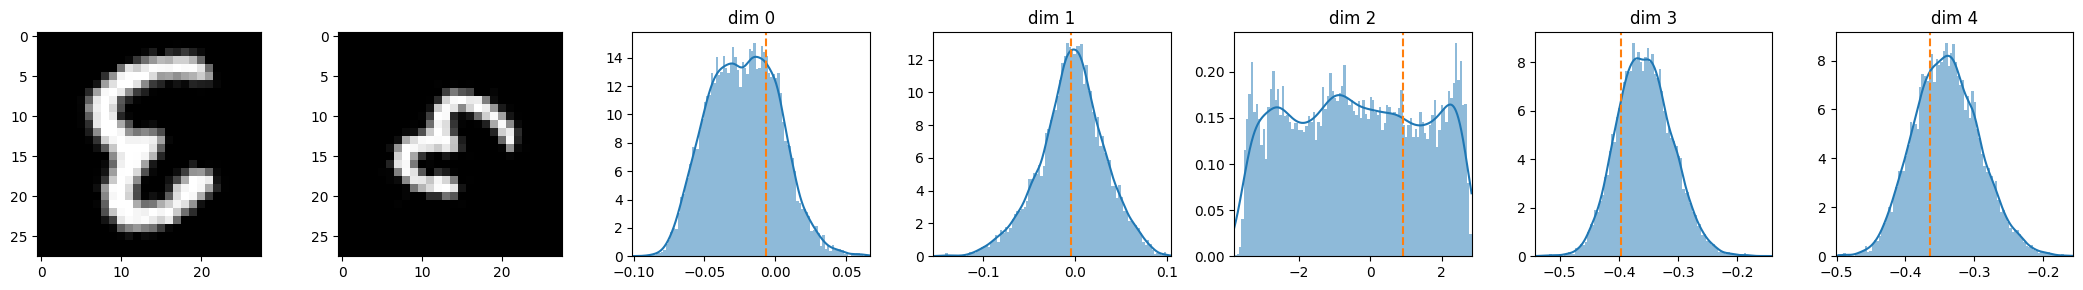

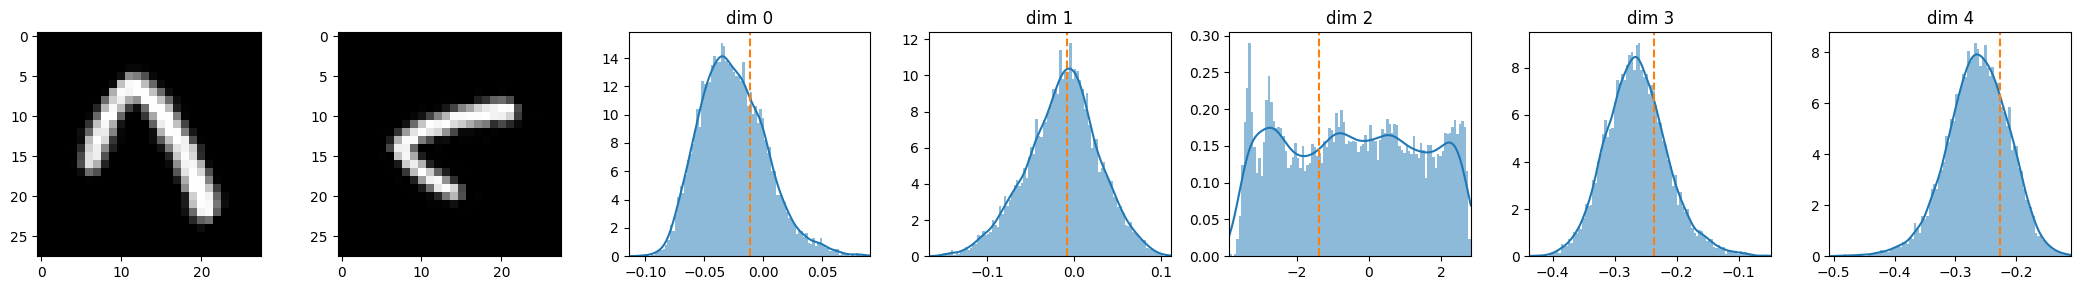

In [14]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)
for i, x in enumerate(
    [
        val_batch["image"][0][14],
        val_batch["image"][0][12],
        # val_batch["image"][0][1],
        # val_batch["image"][0][4],
        # val_batch["image"][0][9],
    ]
):
    fig = plot_gen_dists(
        x,
        prototype_function,
        rng,
        gen_model,
        gen_final_state.params,
        gen_config,
    )
    try:
        run.summary[f"gen_plots_{i}"] = wandb.Image(fig)
    except:
        pass
    plt.show(fig)
    plt.close(fig)

## Train AUG-VAE

In [15]:
rng = random.PRNGKey(vae_config.seed)
data_rng, init_rng = random.split(rng, 2)

In [16]:
train_ds, val_ds, _ = get_data(vae_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]', 'label': 'int64[]'}


In [17]:
aug_vae_model = AUG_VAE(
    vae=vae_config.model.to_dict(),
    inference=inf_config.model.to_dict(),
    generative=gen_config.model.to_dict(),
    interpolation_order=gen_config.interpolation_order,
    bounds=gen_config.get("augment_bounds", None),
    offset=gen_config.get("augment_offset", None),
)

aug_vae_state = create_aug_vae_state(
    aug_vae_model,
    vae_config,
    init_rng,
    input_shape,
    inf_final_state,
    gen_final_state,
)

INFO:absl:
+---------------------------------------------------------------+------------------+-----------+-----------+----------+
| Name                                                          | Shape            | Size      | Mean      | Std      |
+---------------------------------------------------------------+------------------+-----------+-----------+----------+
| params/generative_model/Conditioner_0/Dense_0/bias            | (95,)            | 95        | 0.0       | 0.0      |
| params/generative_model/Conditioner_0/Dense_0/kernel          | (256, 95)        | 24,320    | 0.0       | 0.0      |
| params/generative_model/Conditioner_0/MLP_0/Dense_0/bias      | (256,)           | 256       | 0.0       | 0.0      |
| params/generative_model/Conditioner_0/MLP_0/Dense_0/kernel    | (261, 256)       | 66,816    | -0.000181 | 0.0619   |
| params/generative_model/Conditioner_0/MLP_0/LayerNorm_0/bias  | (256,)           | 256       | 0.0       | 0.0      |
| params/generative_model/Con

In [18]:
train_step, eval_step = make_aug_vae_train_and_eval(aug_vae_model, vae_config)
x = next(deterministic_data.start_input_pipeline(val_ds))["image"][0]
reconstruction_plot, sampling_plot = make_aug_vae_plotting_fns(
    vae_config, aug_vae_model, x
)

2024-01-05 20:55:30.827352: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


    0/10000 [..............................] - ETA: 0s - elbo: -1445.3173 - iwlb: nan - kld: 0.0000e+00 - ll: -1445.3173 - loss: 1445.3173 - x_mse: 0.8821 - elbo_test: -1323.7606 - iwlb_test: nan - kld_test: 0.0068 - ll_test: -1323.7539 - loss_test: 1323.7606 - x_mse_test: 1.3720

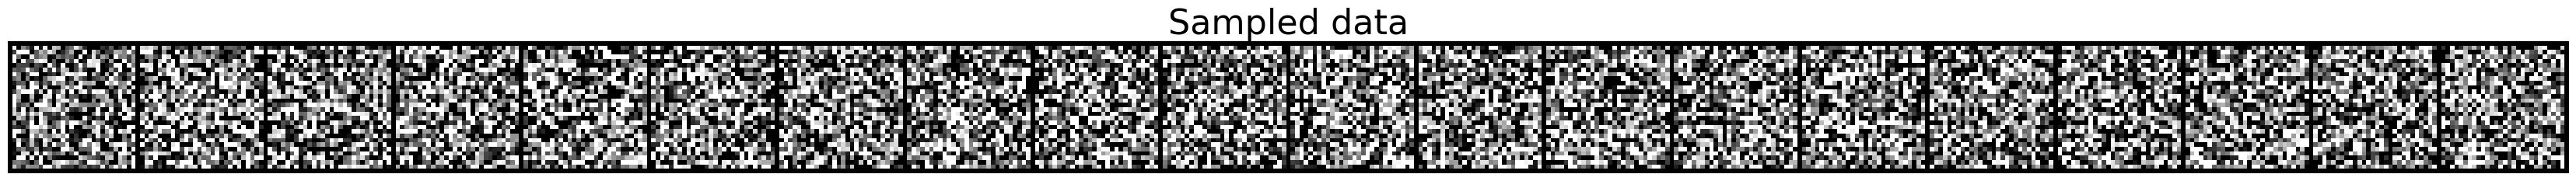

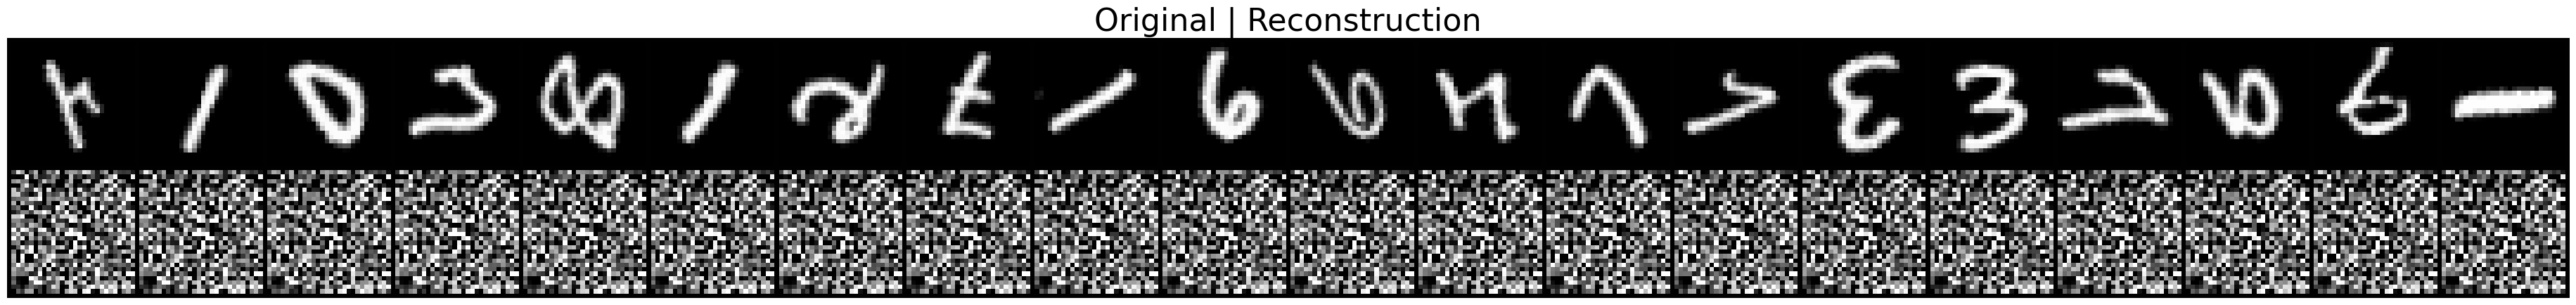

 2500/10000 [======>.......................] - ETA: 10:34 - elbo: 634.1899 - iwlb: nan - kld: 48.9774 - ll: 683.1674 - loss: -634.1899 - x_mse: 0.3820 - elbo_test: 655.4873 - iwlb_test: nan - kld_test: 49.2216 - ll_test: 704.7086 - loss_test: -655.4873 - x_mse_test: 0.0317     37 - ETA: 14:01:15 - elbo: -1102.1428 - iwlb: nan - kld: 0.3853 - ll: -1101.7576 - loss: 1102.1428 - x_mse: 0.8900 - elbo_test: -1323.7606 - iwlb_test: nan - kld_test: 0.0068 - ll_test: -1323.7539 - loss_test: 1323.7606 - x_mse_test: 1.37 - ETA: 11:14:22 - elbo: -1073.6892 - iwlb: nan - kld: 0.5951 - ll: -1073.0941 - loss: 1073.6892 - x_mse: 0.8259 - elbo_test: -1323.7606 - iwlb_test: nan - kld_test: 0.0068 - ll_test: -1323.7539 - loss_test: 1323.7606 - x_mse_test: 1.37 - ETA: 9:23:09 - elbo: -1050.4221 - iwlb: nan - kld: 0.8607 - ll: -1049.5615 - loss: 1050.4221 - x_mse: 0.7705 - elbo_test: -1323.7606 - iwlb_test: nan - kld_test: 0.0068 - ll_test: -1323.7539 - loss_test: 1323.7606 - x_mse_test: 1.3720 - ETA: 8:0

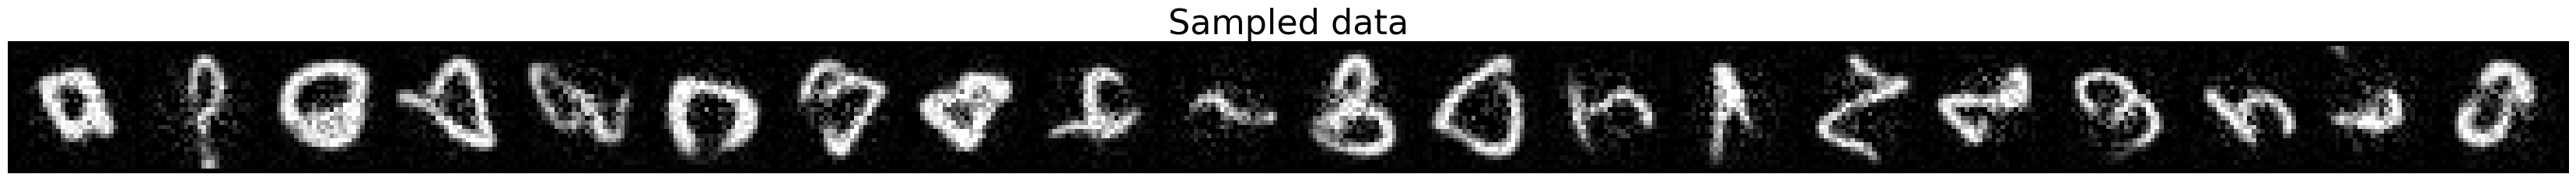

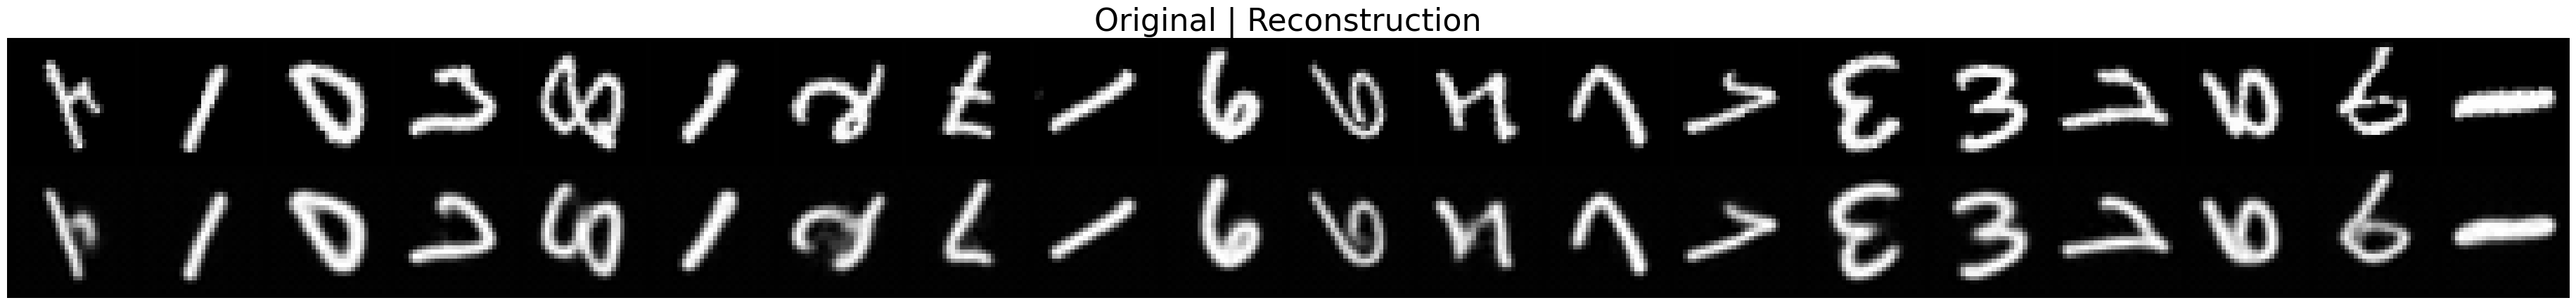

 5000/10000 [==============>...............] - ETA: 6:24 - elbo: 789.8002 - iwlb: nan - kld: 51.0798 - ll: 840.8796 - loss: -789.8002 - x_mse: 0.3788 - elbo_test: 843.5172 - iwlb_test: nan - kld_test: 50.9438 - ll_test: 894.4614 - loss_test: -843.5172 - x_mse_test: 0.0365 - ETA: 10:37 - elbo: 651.9902 - iwlb: nan - kld: 49.0220 - ll: 701.0121 - loss: -651.9902 - x_mse: 0.3822 - elbo_test: 655.4873 - iwlb_test: nan - kld_test: 49.2216 - ll_test: 704.7086 - loss_test: -655.4873 - x_mse_test: 0.031 - ETA: 10:36 - elbo: 652.9530 - iwlb: nan - kld: 49.0462 - ll: 701.9991 - loss: -652.9530 - x_mse: 0.3827 - elbo_test: 655.4873 - iwlb_test: nan - kld_test: 49.2216 - ll_test: 704.7086 - loss_test: -655.4873 - x_mse_test: 0 - ETA: 10:37 - elbo: 654.0002 - iwlb: nan - kld: 49.0424 - ll: 703.0424 - loss: -654.0002 - x_mse: 0.3818 - elbo_test: 655.4873 - iwlb_test: nan - kld_test: 49.2216 - ll_test: 704.7086 - loss_test: -655.4873 - x_mse_test: 0.0 - ETA: 10:36 - elbo: 654.7067 - iwlb: nan - kld: 

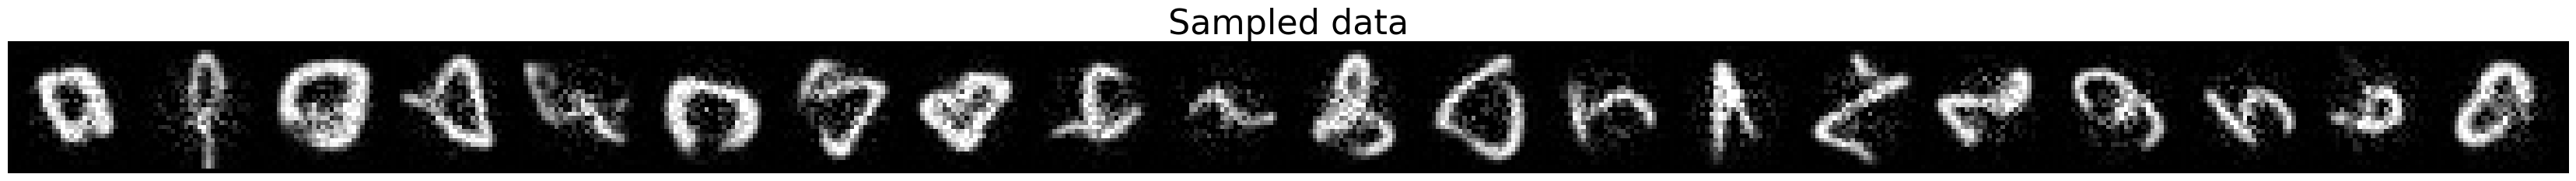

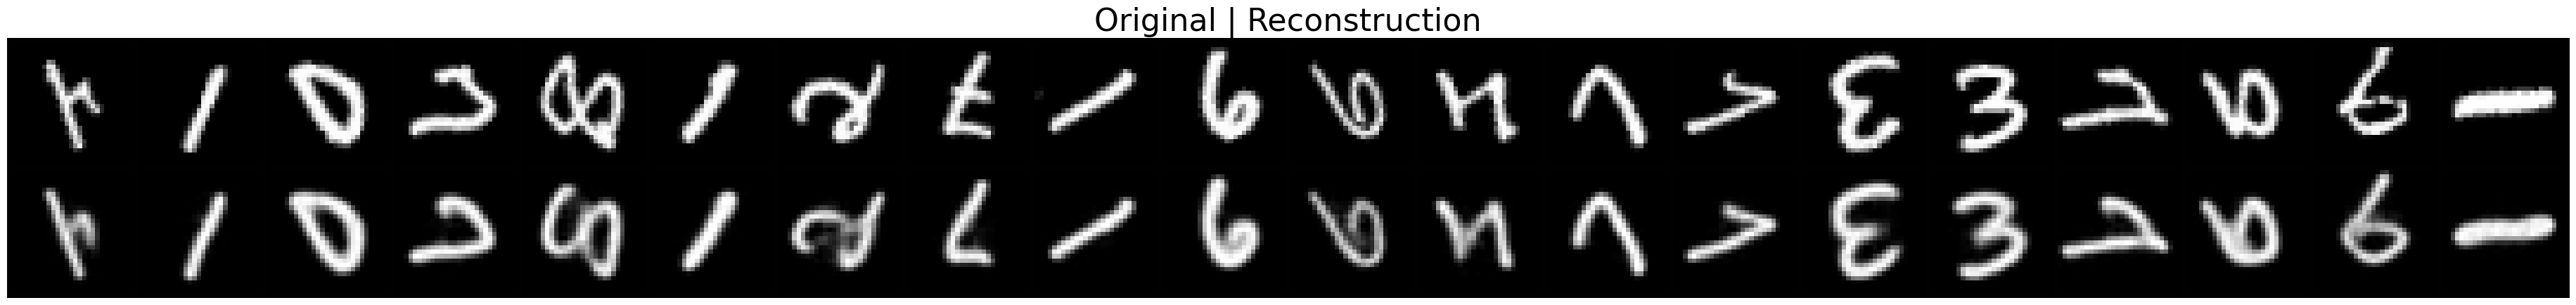

 7500/10000 [=====================>........] - ETA: 3:05 - elbo: 854.0793 - iwlb: nan - kld: 52.3602 - ll: 906.4397 - loss: -854.0793 - x_mse: 0.3794 - elbo_test: 936.2936 - iwlb_test: nan - kld_test: 51.7158 - ll_test: 988.0090 - loss_test: -936.2936 - x_mse_test: 0.0345 ETA: 6:25 - elbo: 790.2905 - iwlb: nan - kld: 51.5812 - ll: 841.8718 - loss: -790.2905 - x_mse: 0.3816 - elbo_test: 843.5172 - iwlb_test: nan - kld_test: 50.9438 - ll_test: 894.4614 - loss_test: -843.5172 - x_mse_test: 0.03 - ETA: 6:25 - elbo: 793.2208 - iwlb: nan - kld: 51.5746 - ll: 844.7953 - loss: -793.2208 - x_mse: 0.3808 - elbo_test: 843.5172 - iwlb_test: nan - kld_test: 50.9438 - ll_test: 894.4614 - loss_test: -843.5172 - x_mse_test - ETA: 6:24 - elbo: 793.0198 - iwlb: nan - kld: 51.3500 - ll: 844.3697 - loss: -793.0198 - x_mse: 0.3817 - elbo_test: 843.5172 - iwlb_test: nan - kld_test: 50.9438 - ll_test: 894.4614 - loss_test: -843.5172 - x_mse_test:  - ETA: 6:24 - elbo: 789.9449 - iwlb: nan - kld: 51.1510 - ll:

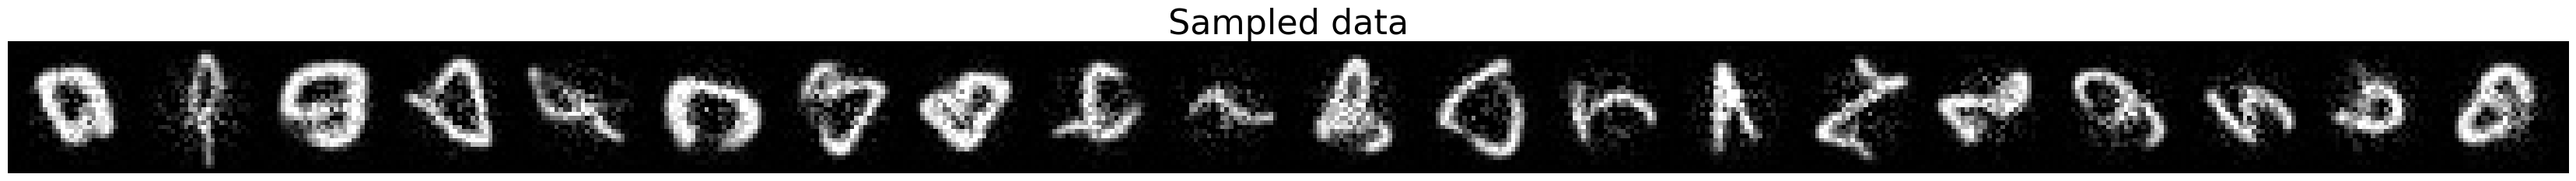

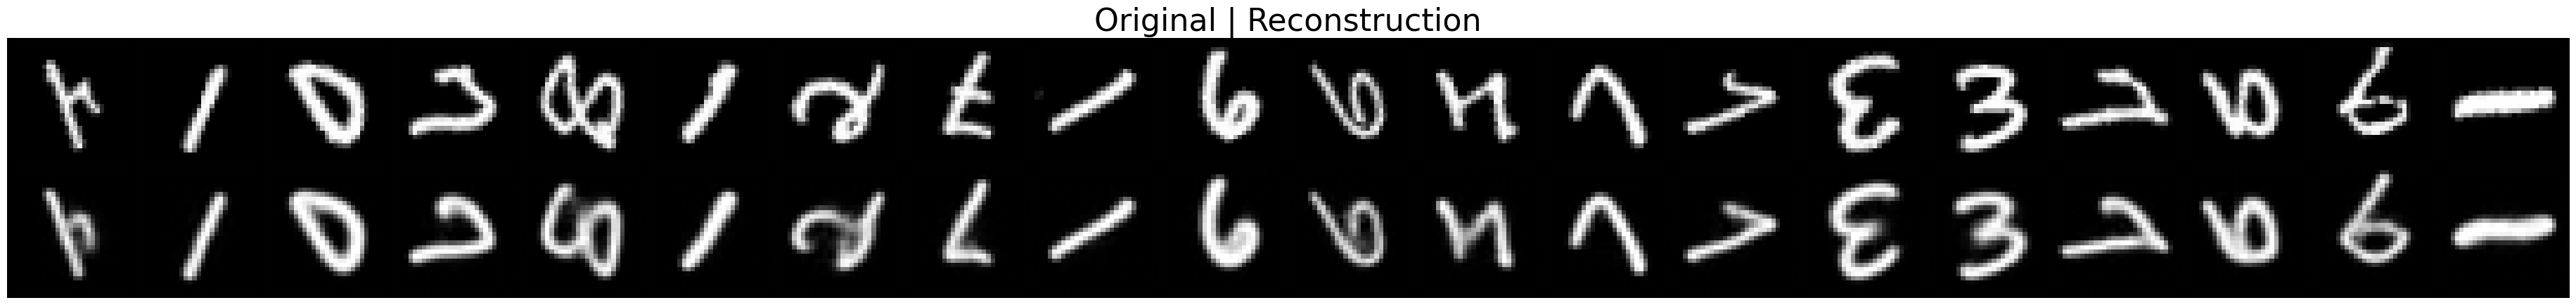

10000/10000 [==============================] - 730s 73ms/step - elbo: 928.6091 - iwlb: nan - kld: 53.6313 - ll: 982.2404 - loss: -928.6091 - x_mse: 0.3828 - elbo_test: 994.0452 - iwlb_test: nan - kld_test: 53.3246 - ll_test: 1047.3695 - loss_test: -994.0452 - x_mse_test: 0.03243:05 - elbo: 888.4719 - iwlb: nan - kld: 52.3442 - ll: 940.8160 - loss: -888.4719 - x_mse: 0.3821 - elbo_test: 936.2936 - iwlb_test: nan - kld_test: 51.7158 - ll_test: 988.0090 - loss_test: -936.2936 - x_mse_test: 0. - ETA: 3:04 - elbo: 885.4504 - iwlb: nan - kld: 52.3878 - ll: 937.8381 - loss: -885.4504 - x_mse: 0.3814 - elbo_test: 936.2936 - iwlb_test: nan - kld_test: 51.7158 - ll_test: 988.0090 - loss_test: -936.2936 - x_mse_test: 0. - ETA: 3:04 - elbo: 883.2536 - iwlb: nan - kld: 52.4573 - ll: 935.7109 - loss: -883.2536 - x_mse: 0.3825 - elbo_test: 936.2936 - iwlb_test: nan - kld_test: 51.7158 - ll_test: 988.0090 - loss_test: -936.2936 - x_mse_test: 0.03 - ETA: 3:04 - elbo: 882.2495 - iwlb: nan - kld: 52.4885

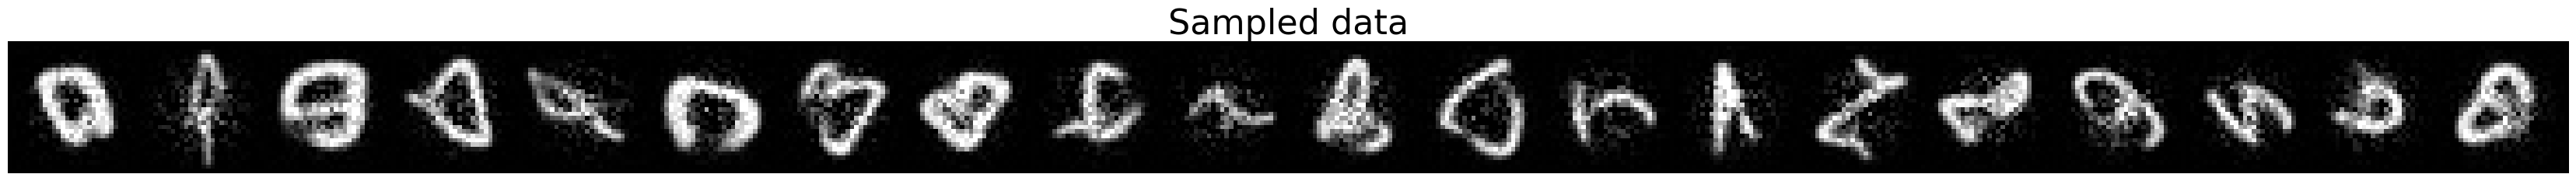

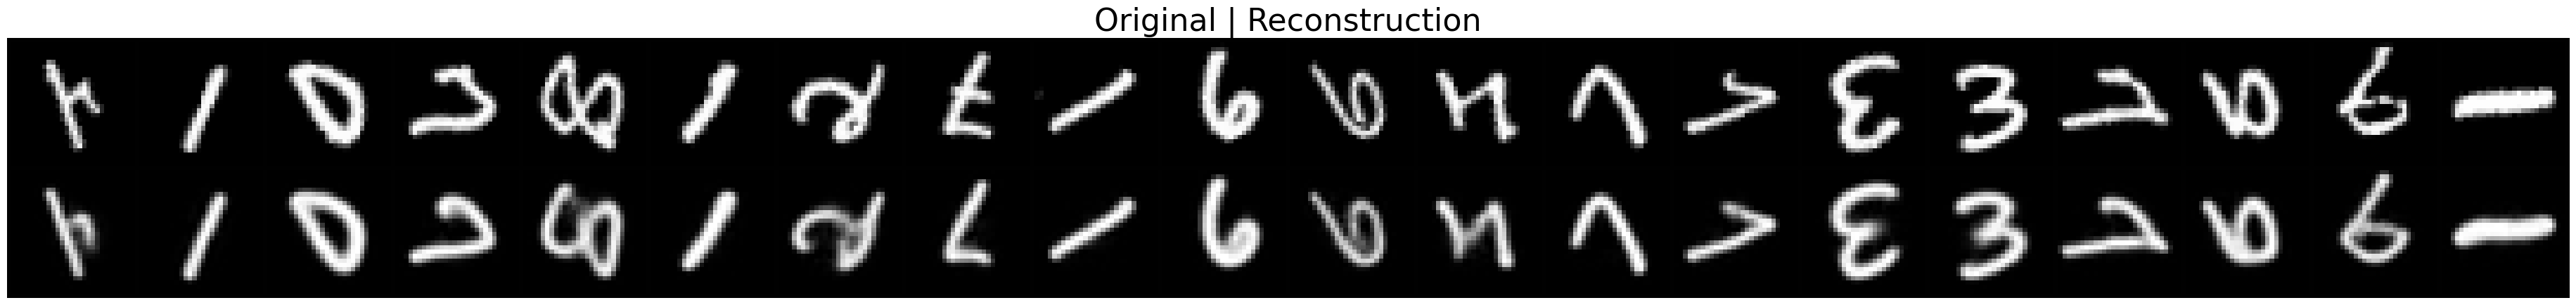

lr,▂▃▅▆██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/elbo,▁▁▃▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇██████████████
train/kld,▁▂▄▅▆▆▇▇▇▇▇▇▇███████████████████████████
train/ll,▁▁▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇██████████████
train/loss,██▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/x_mse,▁▄▇▇████████████████████████████████████
valid/elbo,▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███████████████████
valid/kld,▁▂▅▅▆▇▇▇▇▇▇█████████████████████████████
valid/ll,▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇████████████████████
valid/loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/x_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [19]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=vae_config.to_dict(),
    mode="offline",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

final_aug_vae_state, history, _ = ciclo.train_loop(
    aug_vae_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [train_step],
        ciclo.every(int(vae_config.steps * vae_config.plot_freq)): [
            sampling_plot,
            reconstruction_plot,
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: [
            eval_step,
        ],
        ciclo.every(1): custom_wandb_logger(run=run),
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(vae_config.steps * vae_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=vae_config.steps),
    ],
    stop=vae_config.steps + 1,
)

run.finish()

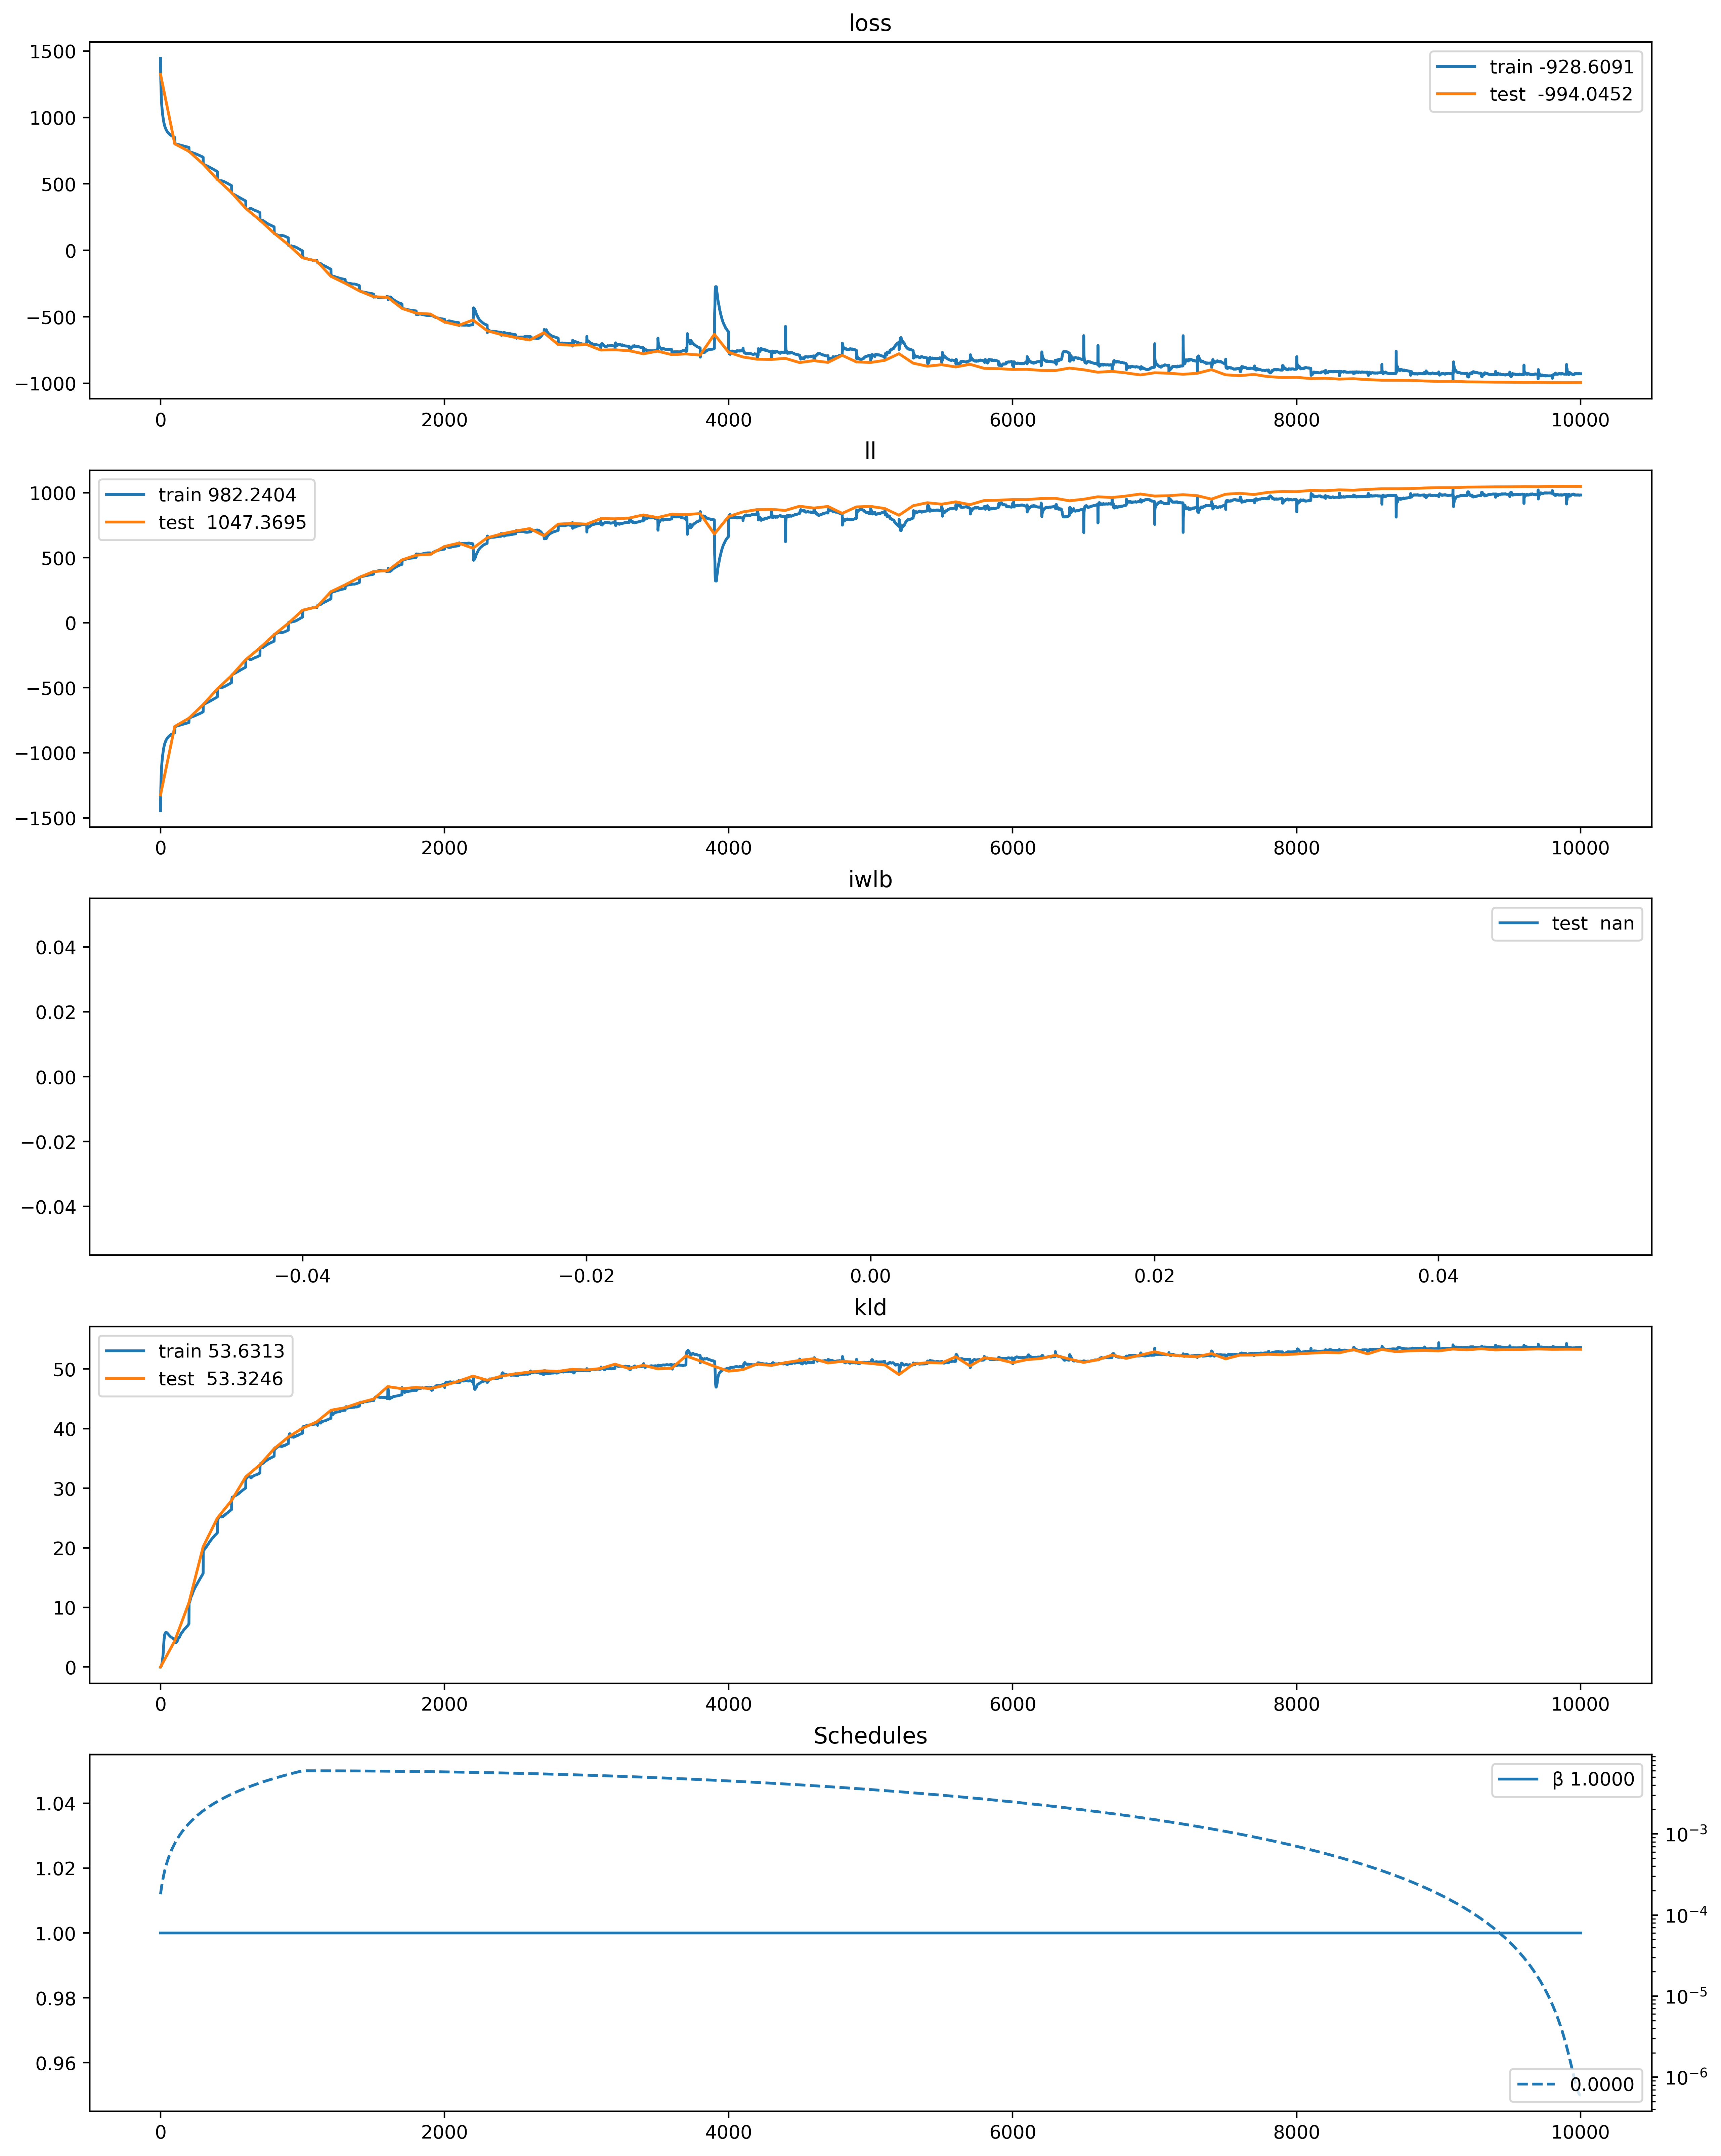

In [20]:
# plot the training history
steps, loss, elbo, ll, kld, lr, β = history.collect(
    "steps", "loss", "elbo", "ll", "kld", "lr", "β"
)
steps_test, loss_test, elbo_test, ll_test, kld_test, iwlb_test = history.collect(
    "steps", "loss_test", "elbo_test", "ll_test", "kld_test", "iwlb_test"
)

n_plots = 5
fig, axs = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, ll, label=f"train {ll[-1]:.4f}")
axs[1].plot(steps_test, ll_test, label=f"test  {ll_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("ll")

axs[2].plot(steps_test, iwlb_test, label=f"test  {iwlb_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("iwlb")

axs[3].plot(steps, kld, label=f"train {kld[-1]:.4f}")
axs[3].plot(steps_test, kld_test, label=f"test  {kld_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("kld")

axs[4].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[4].legend()
axs[4].set_title("Schedules")

ax4_twin = axs[4].twinx()
ax4_twin.plot(steps, lr, "--", label=f"{lr[-1]:.4f}")
ax4_twin.legend(loc="lower right")
ax4_twin.set_yscale("log")

plt.show()

In [22]:
vae_config_test = vae_config.copy_and_resolve_references()
vae_config_test.run_iwlb = True
vae_config_test.test_split = "test"

_, _, test_ds = get_data(vae_config_test, data_rng)
_, test_step = make_aug_vae_train_and_eval(aug_vae_model, vae_config_test)

_, test_history, _ = ciclo.test_loop(
    final_aug_vae_state,
    deterministic_data.start_input_pipeline(test_ds),
    {
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: [
            test_step,
        ],
    },
)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='test', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_m

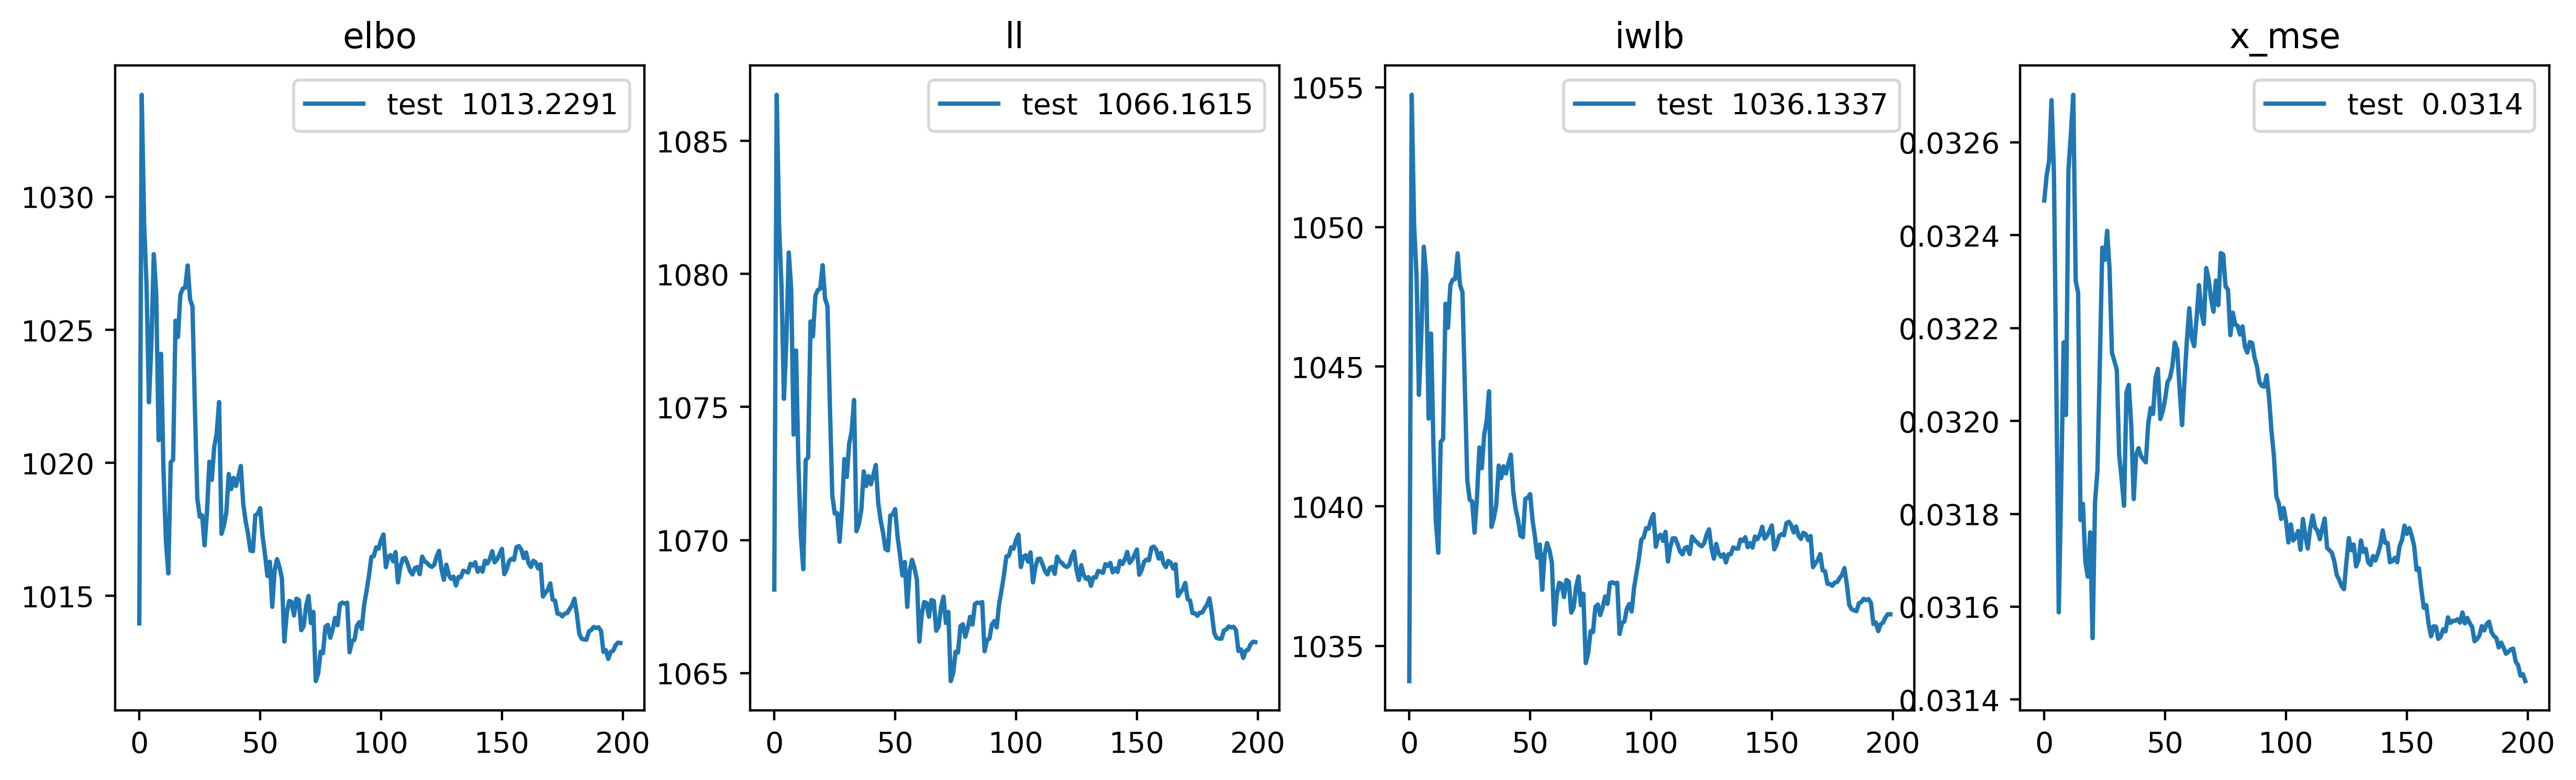

In [23]:
# make a plot of the test history (specifically the ELBO, ll, iwlb)
steps, elbo, ll, iwlb, x_mse = test_history.collect("steps", "elbo", "ll", "iwlb", "x_mse")

fig, axs = plt.subplots(1, 4, figsize=(15, 4), dpi=400)

axs[0].plot(steps, elbo, label=f"test  {elbo[-1]:.4f}")
axs[0].legend()
axs[0].set_title("elbo")

axs[1].plot(steps, ll, label=f"test  {ll[-1]:.4f}")
axs[1].legend()
axs[1].set_title("ll")

axs[2].plot(steps, iwlb, label=f"test  {iwlb[-1]:.4f}")
axs[2].legend()
axs[2].set_title("iwlb")

axs[3].plot(steps, x_mse, label=f"test  {x_mse[-1]:.4f}")
axs[3].legend()
axs[3].set_title("x_mse")

plt.show()